In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mcc = run_casci(scf_checkfile, ncas=4, nroots=4)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py
He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state   0  E = -2.88192509025559  E(CI) = -2.88192509025559  S^2 = 0.0000000
CASCI state   1  E = -1.40116327670131  E(CI) = -1.40116327670131  S^2 = 2.0000000
CASCI state   2  E = -0.951769234759041  E(CI) = -0.951769234759041  S^2 = 0.0000000
CASCI state   3  E = -0.384692858905305  E(CI) = -0.384692858905305  S^2 = 2.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mo_coeff', 'ncas', 'nelecas']>


In [3]:
import importlib, recipes
modules = [recipes]
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in [opt_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
# bosonrecipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, nconfig=100, verbose=False)
recipes.OPTIMIZE(scf_checkfile, opt_checkfile, max_iterations=2, nconfig=1000, verbose=True)
# Jastrow optimization results
df = pyq.read_opt(opt_checkfile)
df

starting warmup
finished warmup
----------vmc done
Gradient norm:  0.7146184236382381
Dot product between gradient and SR step:  0.8895557819002122
descent en -2.710561317737228 0.030905794857524614
energies from correlated sampling [-2.53027937 -2.73542981 -2.83866844 -2.86966599 -2.85138617]
----------vmc done
Gradient norm:  0.09171283540772034
Dot product between gradient and SR step:  0.9712103312017082
descent en -2.8743821275670194 0.004095442380843899
energies from correlated sampling [-2.88228314 -2.89041341 -2.89749334 -2.90352226 -2.90849848]


,energy,iteration,error,fname
0,-2.710561,0,0.030906,he-sj.hdf5
1,-2.874382,1,0.004095,he-sj.hdf5


In [4]:
def limdrift(g, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    return g

In [5]:
# Multi determinant boson new gradient
import importlib, recipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, wftools, mc
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, wftools, mc] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools

nconfig = 323
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    
wf, to_opt = bosonwftools.generate_boson_wf(
        mol, mf)

load_parameters = opt_checkfile
wftools.read_wf(wf, load_parameters)      

In [6]:
configs = mc.fixed_initial_guess(mol, nconfig)
e=0


In [7]:
sign, val = wf.recompute(configs)


Text(0.5, 1.0, 'Single determinant with jastrow gradient $\\Psi(R, R2) $, R2=[-0.1  0.9 -1. ]')

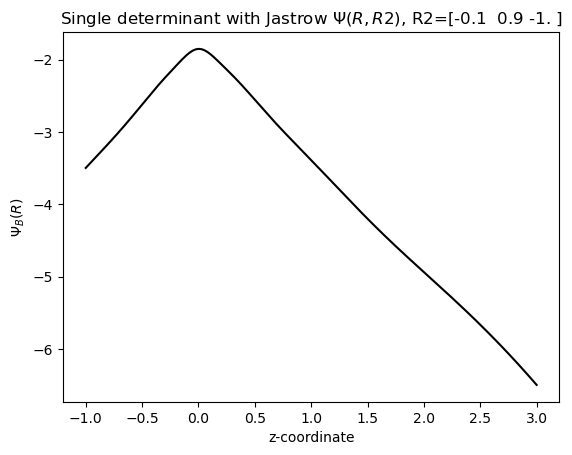

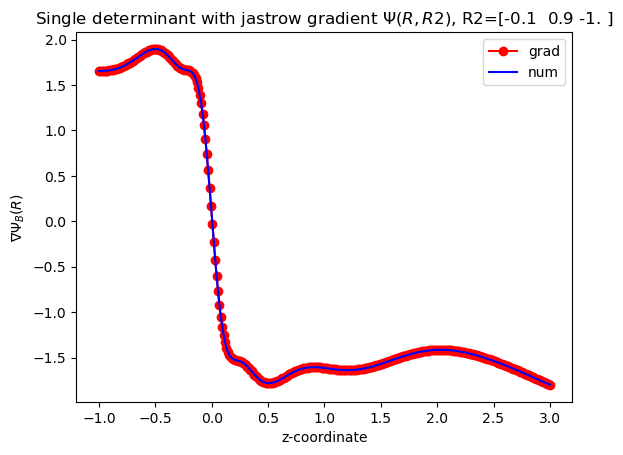

In [8]:
g1, _, _ = wf.gradient_value(e, configs.electron(e))

# val2 = saved['psi']
_, psi1 = wf.value()

y1 = np.gradient(val)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]
# print(dx)

x = configs.configs[:,0][:,2]
h1 = (0,0, 0.0)
h2 = (2.0, 0.0)
e2pos = np.array2string(configs.configs[:,1][0])




plt.figure()
plt.plot(x,val, '-k', label='recompute')
# plt.plot(x,val2, '-sb', label='from_grad')
# plt.plot(x,psi1, '-sr', label='from_val')
# plt.legend()
plt.xlabel('z-coordinate')
plt.ylabel(r'$\Psi_B(R)$')
plt.title('Single determinant with Jastrow $\Psi(R, R2) $, R2={}'.format(e2pos) )

plt.figure()
plt.plot(x,g1[2], '-or', label='grad')
plt.plot(x,y1/dx, '-b', label='num')
plt.xlabel('z-coordinate')
plt.ylabel(r'$\nabla\Psi_B(R)$')
plt.legend()
plt.title('Single determinant with jastrow gradient $\Psi(R, R2) $, R2={}'.format(e2pos) )


